In [1]:
# from sklearn.gaussian_process import GaussianProcessRegressor
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split as tts
# from sklearn import svm
# from sklearn.linear_model import SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
# from sklearn.kernel_ridge import KernelRidge
# from sklearn.cross_decomposition import PLSRegression
# from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
# from sklearn.linear_model import ElasticNet
from sklearn import linear_model
from sklearn.decomposition import PCA
# from sklearn.neural_network import MLPRegressor
import xgboost
from matplotlib import pyplot as plt
import seaborn as sb

In [2]:
def punish(x):
    res = 1
    if x < 50:
        res = np.sin(x/100+1)
    if x > 112:
        res = np.log(x-109.5)/np.sqrt(x-111)
    if x > 200:
        res -= 10/x*np.log(x/20)
    return min(res,1)        
def fun(row):
    if row.State_CA:
        return "CA"
    if row.State_CO:
        return "CO"
    if row.State_NV:
        return "NV"
    return "AZ"

Punish = []
df = pd.read_csv('RealEstateData.csv',sep='\t')

counties = pd.read_csv("counties.csv",index_col=0)
df = df.join(pd.get_dummies(counties,drop_first=True))
for index,row in df.iterrows():
    
    Punish.append(punish(row.DaysOnMarket))

# set month sold values
posted = df.DatePosted
sold = df.DateSold
seasonPosted = np.array([int(i[:2]) for i in list(posted)])
seasonSold = np.array([int(i[:2]) for i in list(sold)])
df['MonthPosted'] = seasonPosted
df['MonthSold'] = seasonSold
a=pd.get_dummies(df["MonthPosted"],drop_first=True,dtype='int64')
a=a.rename({2:"Posted_Feb",
            3:"Posted_Mar",
            4:"Posted_Apr",
            5:"Posted_May",
            6:"Posted_June",
            7:"Posted_July",
            8:"Posted_Aug",
            9:"Posted_Sept",
            10:"Posted_Oct",
            11:"Posted_Nov",
            12:"Posted_Dec"},axis=1)
# b = pd.get_dummies(df['MonthSold'],drop_first=True,dtype=int)
# b=b.rename({2:"Sold_Feb",
#             3:"Sold_Mar",
#             4:"Sold_Apr",
#             5:"Sold_May",
#             6:"Sold_June",
#             7:"Sold_July",
#             8:"Sold_Aug",
#             9:"Sold_Sept",
#             10:"Sold_Oct",
#             11:"Sold_Nov",
#             12:"Sold_Dec"},axis=1,)
df=df.join(a)
# df=df.join(b)

df['Marketability'] = Punish

# ca_avg = df[df.State_CA == 1].SoldPrice.median()
# co_avg = df[df.State_CO == 1].SoldPrice.median()
# nv_avg = df[df.State_NV == 1].SoldPrice.median()
# az_avg = (df[df.State_CA == 0][df.State_NV == 0][df.State_CO == 0]).SoldPrice.median()
# PriceAvg = []
# for index,row in df.iterrows():
#     if row.State_CA == 1:
#         PriceAvg.append(ca_avg)
#     elif row.State_CO == 1:
#         PriceAvg.append(co_avg)
#     elif row.State_NV == 1:
#         PriceAvg.append(nv_avg)
#     else:
#         PriceAvg.append(az_avg)

# df['PriceAvg'] = PriceAvg
# df = df.join(pd.get_dummies(df["Zipcode"],drop_first=True, prefix='zip_'))
# df = df.join(pd.get_dummies(df["City"],drop_first=True))
df.drop(["City","Zipcode","DateSold","MonthPosted","MonthSold",'DatePosted'], axis=1, inplace=True)
df.columns

Index(['Bedrooms', 'Bathrooms', 'HouseSize(sqft)', 'LotSize(acre)',
       'YearBuilt', 'Stories', 'SoldPrice', 'UtilityCosts',
       'ElementarySchoolRating', 'DaysOnMarket',
       ...
       'Posted_Apr', 'Posted_May', 'Posted_June', 'Posted_July', 'Posted_Aug',
       'Posted_Sept', 'Posted_Oct', 'Posted_Nov', 'Posted_Dec',
       'Marketability'],
      dtype='object', length=144)

In [15]:
# OUR OVERALL TRAINING/TESTING SPLITS
X_train,X_val,y_train,y_val = tts(df.drop("SoldPrice",axis=1),
                                    df.SoldPrice,
                                    test_size=0.2,
                                    random_state=40)
X_train.columns
# X_train,X_test,y_train,y_test = tts(X_train,
#                                     y_train,
#                                     test_size=0.2,
#                                     random_state=40)


Index(['Bedrooms', 'Bathrooms', 'HouseSize(sqft)', 'LotSize(acre)',
       'YearBuilt', 'Stories', 'UtilityCosts', 'ElementarySchoolRating',
       'DaysOnMarket', 'Foreclosed_True',
       ...
       'Posted_Apr', 'Posted_May', 'Posted_June', 'Posted_July', 'Posted_Aug',
       'Posted_Sept', 'Posted_Oct', 'Posted_Nov', 'Posted_Dec',
       'Marketability'],
      dtype='object', length=143)

In [4]:
X_train["Target"] = y_train
C_mat = X_train.corr()
fig = plt.figure(figsize = (15,15))

sb.heatmap(C_mat, vmax = .8, square = True)
plt.show()

In [5]:
X_train["Target"] = y_train
C_mat = X_train.corr("kendall")
fig = plt.figure(figsize = (15,15))

sb.heatmap(C_mat, vmax = .8, square = True)
plt.show()

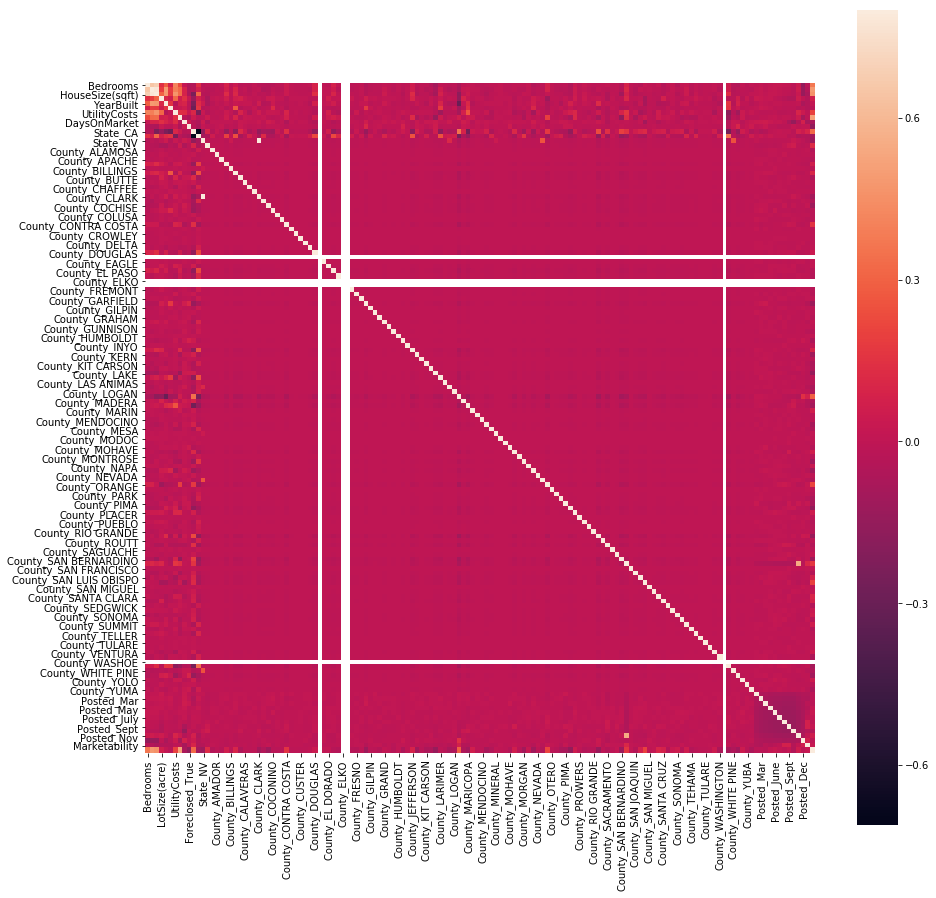

In [6]:
X_train["Target"] = y_train
C_mat = X_train.corr("spearman")
fig = plt.figure(figsize = (15,15))

sb.heatmap(C_mat, vmax = .8, square = True)
plt.show()

In [99]:
def score(X,y,model,accuracy=0.2):
    yhat = model.predict(X)
    y = y.values
    return sum([np.linalg.norm(y[i]-yhat[i])< y[i]*accuracy for i in range(len(y))])/len(y)

# Support Vector Machines

In [ ]:
%%time
# Gridsearch for SVMs, which didn't work properly...
pipe = Pipeline([('gbr',svm.SVR())])
param_grid = [{'gbr__kernel':['linear', 'poly', 'rbf', 'sigmoid','precomputed'],
               'gbr__gamma':np.arange(0.01,1,0.04),
               'gbr__shrinking':[True,False],
               'gbr__degree':np.arange(3,7,1),
               'gbr__coef0':np.arange(0,4,1),
               'gbr__epsilon':np.arange(0.01,0.11,0.02),
               'gbr__C':np.arange(0.1,3,0.5)}]
gs = GridSearchCV(pipe, 
                  param_grid, 
                  cv=3,
                  verbose=1,
                  n_jobs=-1)
gs.fit(XPrice_train,yPrice_train)
print(gs.best_params_,gs.best_score_)
print(gs.score(XPrice_test,yPrice_test))
print('-'*42)

In [5]:
# for x in ["linear",'poly', 'rbf', 'sigmoid', 'precomputed']:
model = svm.SVR(gamma='scale')
model.fit(X_train,y_train)
# print(x)
print(model.score(X_test,y_test))
print(score(X_test,y_test,model))
print(score(X_val,y_val,model))
print('-'*42)

0.2044002623745731
0.27489916227117595
0.2827355094948492
------------------------------------------


# K-Nearest Neighbors Regression

In [101]:
for k in range(2,10,2):
    model = KNeighborsRegressor(2**k,n_jobs=-1)
    model.fit(X_train,y_train)
    print("k=",2**k)
    print(model.score(X_test,y_test))
    print(score(X_test,y_test,model))
    print(score(X_val,y_val,model))
    print('-'*42)

k= 4
0.180638667474061
0.35246664598200433
0.33734640685118533
------------------------------------------
k= 16
0.2547740325036886
0.3274899162271176
0.32481072359438995
------------------------------------------
k= 64
0.03182461013723614
0.295221843003413
0.2956435397790741
------------------------------------------
k= 256
0.1844311816512333
0.24185541421036302
0.2561747548715403
------------------------------------------


In [63]:
for k in range(3,20,3):
    model = KNeighborsRegressor(k,n_jobs=-1)
    model.fit(data,y_train)
    print("k=",k)
#     print(model.score(X_test,y_test))
#     print(score(X_test,y_test,model))
    print(l2(pca.fit_transform(X_val),y_val,model))
    print('-'*42)

k= 3
0.23581978403872408
------------------------------------------
k= 6
0.24438376566960407
------------------------------------------
k= 9
0.24798312026808986
------------------------------------------
k= 12
0.2513342435149559
------------------------------------------
k= 15
0.25890529973935705
------------------------------------------
k= 18
0.2612634975797443
------------------------------------------


# Kernel Ridge Regressor

In [8]:
# %%time
model = KernelRidge()
model.fit(X_train,y_train)
print(model.score(X_test,y_test))
print(score(X_test,y_test,model))
print(score(X_val,y_val,model))
print('-'*42)

0.1427397247226293
0.41234874340676386
0.4125605063919573
------------------------------------------


# Partial Least Squares Regression

In [ ]:
model = PLSRegression()
model.fit(X_train,y_train)
print(model.score(X_test,y_test))
print(score(X_test,y_test,model))
print(score(X_val,y_val,model))

0.12362195372752272
0.4452373565001551
0.44098299615241404


# XGBoost Regression

In [85]:
model = xgboost.XGBRegressor(n_jobs=-1,n_estimators=200)
model.fit(X_train,y_train)
# print(model.evals_result())
print('Price accuracy score:',model.score(X_test,y_test))
print(score(X_test,y_test,model))
print(score(X_val,y_val,model))
print('-'*42)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Price accuracy score: -23.181675522112183
0.39264660254421346
0.4098299615241405
------------------------------------------


In [16]:
X_nobed = X_train.drop(["Bedrooms"],axis=1)
X_nobed_houseSize = X_train.drop(["Bedrooms","HouseSize(sqft)"],axis=1)

In [17]:
model_nobed = xgboost.XGBRegressor(learning_rate=0.2, 
                             gamma=0,
                             booster='dart',
                             n_estimators=200,
                             max_depth=7,
                             random_state=42,
                             reg_alpha=0, n_jobs=-1,
                             reg_lambda=1.8)
model_nobed.fit(X_nobed,y_train)
print(l2(model_nobed,X_val.drop(["Bedrooms"],axis=1),y_val))

model = xgboost.XGBRegressor(learning_rate=0.2, 
                             gamma=0,
                             booster='dart',
                             n_estimators=200,
                             max_depth=7,
                             random_state=42,
                             reg_alpha=0, n_jobs=-1,
                             reg_lambda=1.8)
model.fit(X_train,y_train)
print(l2(model,X_val,y_val))

model_nobed_house = xgboost.XGBRegressor(learning_rate=0.2, 
                             gamma=0,
                             booster='dart',
                             n_estimators=200,
                             max_depth=7,
                             random_state=42,
                             reg_alpha=0, n_jobs=-1,
                             reg_lambda=1.8)
model_nobed_house.fit(X_nobed_houseSize,y_train)

# print(model.evals_result())
# print('Price accuracy score:',model.score(data,y_test))
# print(score(X_test,y_test,model))
print(l2(model_nobed_house,X_val.drop(["Bedrooms","HouseSize(sqft)"],axis=1),y_val))
print('-'*42)

0.6279012039220554
0.6271565098671962
0.5947623184808242
------------------------------------------


In [27]:
fig = plt.figure(figsize=(15,10))
plt.subplot(131)
yhat = model_nobed_house.predict(X_val.drop(["Bedrooms","HouseSize(sqft)"],axis=1))
plt.plot(y_val,yhat,'r.',ms=3)
plt.plot([x for x in range(21)],'k--')
plt.xlabel("True Values")
plt.ylabel("Estimated Values")
plt.title("No Bedrooms or House Size")
plt.subplot(132)
yhat = model_nobed.predict(X_val.drop(["Bedrooms"],axis=1))
plt.plot(y_val,yhat,'r.',ms=3)
plt.plot([x for x in range(21)],'k--')
plt.xlabel("True Values")
plt.ylabel("Estimated Values")
plt.title("No Bedrooms")
plt.subplot(133)
yhat = model.predict(X_val)
plt.plot(y_val,yhat,'r.',ms=3)
plt.plot([x for x in range(21)],'k--')
plt.xlabel("True Values")
plt.ylabel("Estimated Values")
plt.title("Original Data")
plt.plot()
plt.show()

0.6322452525754003


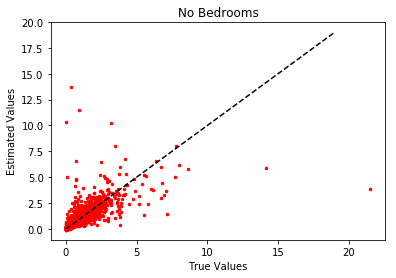

In [36]:
Xval_nobed = X_val.drop("Bedrooms",axis=1)
print(l2(model,Xval_nobed,y_val))

yhat = model.predict(Xval_nobed)
plt.plot(y_val,yhat,'r.',ms=5)
plt.plot([x for x in range(20)],'k--')
plt.xlabel("True Values")
plt.ylabel("Estimated Values")
plt.title("No Bedrooms")
plt.plot()
plt.show()

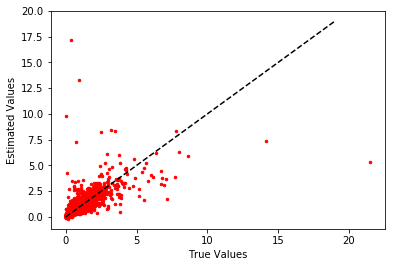

In [30]:
yhat = model.predict(X_val)
plt.plot(y_val,yhat,'r.',ms=5)
plt.plot([x for x in range(100)],'k--')
plt.xlabel("True Values")
plt.ylabel("Estimated Values")
plt.plot()
plt.show()

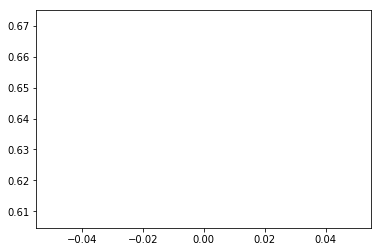

In [31]:
plt.plot(l2(model,X_val,y_val))

In [7]:
def mse(X,y,model):
    yhat = model.predict(X)
    y = y.values
    return sum([(y[i]-yhat[i])**2 for i in range(len(y))])/len(y)
# print(mse(X_test,y_test,gs))
def l2(model,X,y,accuracy=0.22):
    yhat = model.predict(X)
    y = y.values
    return sum([abs((y[i]-yhat[i]))< y[i]*accuracy for i in range(len(y))])/len(y)
def customScorer(y_true,y_predict):
    sum([abs((y_true[i]-y_predict[i]))< y_true[i]*0.22 for i in range(len(y))])/len(y_predict)
# print(l2(pca.fit_transform(X_val),y_val,model))

In [19]:
#https://xgboost.readthedocs.io/en/latest/python/python_api.html
pipe = Pipeline([('xgbc',xgboost.XGBRegressor(predictor='cpu_predictor',n_estimators=200))])
param_grid = [{'xgbc__learning_rate':np.linspace(0.2,1,8),
               'xgbc__booster':['dart'],
               'xgbc__max_depth':np.arange(5,8),
               'xgbc__gamma':np.linspace(0,1,6),
               'xgbc__reg_lambda':np.linspace(1,10,9)}]
gs = GridSearchCV(pipe, 
                  param_grid, scoring=l2,
                  cv=3,
                  verbose=1,
                  n_jobs=-1)
gs.fit(X_train,y_train)
print(gs.best_params_,gs.best_score_,'\n\n')
print(gs.score(X_val,y_val))
print(score(X_val,y_val,gs))

Fitting 3 folds for each of 1296 candidates, totalling 3888 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 42.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 91.7min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 159.0min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 234.3min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 330.0min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 434.7min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 546.7min
[Parallel(n_jobs=-1)]: Done 3888 out of 3888 | elapsed: 647.6min finished


{'xgbc__booster': 'dart', 'xgbc__gamma': 0.0, 'xgbc__learning_rate': 0.2, 'xgbc__max_depth': 7, 'xgbc__reg_lambda': 1.0} 0.6302283728434901 


0.6372098796077945


NameError: name 'score' is not defined

In [160]:
model = xgboost.XGBRegressor(learning_rate=0.3, 
                             gamma=0.8,
                             booster='dart',
                             n_estimators=200,
                             max_depth=9,
                             random_state=42,
                             n_jobs=-1,
                             reg_lambda=7)
model.fit(X_train,y_train)
# print(model.evals_result())
print('Price accuracy score:',model.score(X_test,y_test))
print(l2(X_test,y_test,model))
print(l2(X_val,y_val,model))
print('-'*42)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Price accuracy score: -89.16262593760231
0.5454545454545454
0.5488395184311778
------------------------------------------


# Gradient Boosting Trees Regressor

In [94]:
print('I printed all the information under this cell. Took 707 minutes.')
print('-'*42)
# GBT gridsearch. Definitely not re-running this again...
pipe = Pipeline([('gbr',GradientBoostingRegressor(n_estimators=500,max_depth=6))])
param_grid = [{'gbr__loss':['ls', 'lad', 'huber', 'quantile'],
               'gbr__learning_rate':np.arange(0.1,1.1,0.1),
               'gbr__alpha':np.linspace(0.1,0.99,8),
               'gbr__warm_start':[True,False]}]
gs = GridSearchCV(pipe, 
                  param_grid, 
                  cv=7,
                  verbose=1,
                  n_jobs=-1)
gs.fit(X_train,y_train)
print(gs.best_params_,gs.best_score_)
print(gs.score(X_test,y_test))
print("Most important features:\n")
print(X_train.columns[model.feature_importances_>0.05])

I printed all the information under this cell. Took 707 minutes.
------------------------------------------
Fitting 7 folds for each of 640 candidates, totalling 4480 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 31.6min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 67.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 121.3min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 192.5min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 279.3min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 384.1min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 504.0min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 642.1min
[Parallel(n_jobs=-1)]: Done 4480 out of 4480 | elapsed: 710.2min finished


{'gbr__alpha': 0.99, 'gbr__learning_rate': 0.30000000000000004, 'gbr__loss': 'huber', 'gbr__warm_start': False} 0.8128490906033462
0.8649449891310053
Most important features:

Index(['Bathrooms', 'HouseSize(sqft)', 'YearBuilt', 'DaysOnMarket',
       'Marketability'],
      dtype='object')


In [11]:
X_traingbr,X_valgbr,y_traingbr,y_valgbr = tts(df.drop("SoldPrice",axis=1),
                                    df.SoldPrice,
                                    test_size=0.2,
                                    random_state=40)
# prev: {'gbr__alpha': 0.99, 'gbr__learning_rate': 0.30000000000000004, 'gbr__loss': 'huber', 'gbr__warm_start': False}
gs = GradientBoostingRegressor(n_estimators=1000,validation_fraction=0.2,max_depth=6,alpha=0.99,learning_rate=0.4,loss='huber',warm_start=True)
gs.fit(X_traingbr,y_traingbr)
print(gs.score(X_valgbr,y_valgbr))
print(score(X_valgbr,y_valgbr,gs))
print('-'*42)

0.757487208238064
0.6928137023706095
------------------------------------------


# Linear Models

In [5]:
regr = ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=40, selection='cyclic', tol=1e-3, warm_start=True)
regr.fit(X_train, y_train)
print(regr.score(X_test,y_test))
print(score(X_val,y_val,regr))

0.2095126101732
0.20764552562988706


In [6]:
regr = linear_model.Lars(n_nonzero_coefs=1)
regr.fit(X_train, y_train)
print(regr.score(X_test,y_test))
print(score(X_val,y_val,regr))

-0.04857151776530011
0.19883331264738738


In [7]:
regr = linear_model.OrthogonalMatchingPursuit()
regr.fit(X_train, y_train)
print(regr.score(X_test,y_test))
print(score(X_val,y_val,regr))

0.12224126102373047
0.3970460469157255


In [8]:
regr = linear_model.BayesianRidge()
regr.fit(X_train, y_train)
print(regr.score(X_test,y_test))
print(score(X_val,y_val,regr))

0.4665999039378667
0.30048405113565846


In [9]:
regr = linear_model.SGDRegressor(max_iter=1000, tol=1e-3)
regr.fit(X_train, y_train)
print(regr.score(X_test,y_test))
print(score(X_val,y_val,regr))

-6.251262789616953e+30
0.0


In [10]:
model = MLPRegressor(learning_rate='adaptive')
# model.n_layers_ = 400
model.fit(X_train,y_train)
print(model.score(X_test,y_test))
print(score(X_test,y_test,model))

-0.6532416645403414
0.2407694694384114


In [ ]:
import pickle

pickle.dump(model, open("PricingModel", 'wb'))

In [31]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [32]:
model = LinearDiscriminantAnalysis()
model.fit(X_train,y_train)
print(model.score(X_test,y_test))
print(score(X_test,y_test,model))

ValueError: Unknown label type: (array([0.104, 0.801, 0.125, ..., 0.185, 0.26 , 0.48 ]),)

In [ ]:
def punish(x):
    res = 1
    if x < 50:
        res = np.sin(x/100+1)
    if x > 112:
        res = np.log(x-109.5)/np.sqrt(x-111)
    if x > 200:
        res -= 10/x*np.log(x/20)
    return min(res,1)
dom = np.linspace(0,300,500)
plt.plot(dom,[f(x) for x in dom])

In [80]:
df.to_csv("EngineeredData.csv",sep='\t')

# Neural Nets

In [1]:
print(len(X_train),len(y_train))

NameError: name 'X_train' is not defined

In [ ]:
# build the model
def baseline_model():
    # create model
    model = Sequential()
    m = len(X_train.columns)
    model.add(Dense(m, input_dim = m, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

seed = 7
numpy.random.seed(seed)
# evaluate model with standardized dataset
estimator = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=5, verbose=0)
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(estimator, X_train, y_train, cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))
#Baseline: 31.64 (26.82) MSE            

- https://keras.io/layers/normalization/
- https://keras.io/layers/core/
- https://keras.io/initializers/
- https://keras.io/regularizers/

The original paper on Dropout provides experimental results on a suite of standard machine learning problems. As a result they provide a number of useful heuristics to consider when using dropout in practice.

- Generally, use a small dropout value of 20%-50% of neurons with 20% providing a good starting point. A probability too low has minimal effect and a value too high results in under-learning by the network.
- Use a larger network. You are likely to get better performance when dropout is used on a larger network, giving the model more of an opportunity to learn independent representations.
- Use dropout on incoming (visible) as well as hidden units. Application of dropout at each layer of the network has shown good results.
- Use a large learning rate with decay and a large momentum. Increase your learning rate by a factor of 10 to 100 and use a high momentum value of 0.9 or 0.99.
- Constrain the size of network weights. A large learning rate can result in very large network weights. Imposing a constraint on the size of network weights such as max-norm regularization with a size of 4 or 5 has been shown to improve results.

In [ ]:
https://stackoverflow.com/questions/37232782/nan-loss-when-training-regression-network

In [164]:
def punish(x):
    res = 1
    if x < 50:
        res = np.sin(x/100+1)
    if x > 112:
        res = np.log(x-109.5)/np.sqrt(x-111)
    if x > 200:
        res -= 10/x*np.log(x/20)
    return min(res,1)        
def fun(row):
    if row.State_CA:
        return "CA"
    if row.State_CO:
        return "CO"
    if row.State_NV:
        return "NV"
    return "AZ"

Punish = []
rdf = pd.read_csv('RealEstateData.csv',sep='\t')

# counties = pd.read_csv("counties.csv",index_col=0)
# df = df.join(pd.get_dummies(counties,drop_first=True))
for index,row in rdf.iterrows():
    Punish.append(punish(row.DaysOnMarket))

# set month sold values
# posted = df.DatePosted
# sold = df.DateSold
# seasonPosted = np.array([int(i[:2]) for i in list(posted)])
# seasonSold = np.array([int(i[:2]) for i in list(sold)])
# df['MonthPosted'] = seasonPosted
# df['MonthSold'] = seasonSold
# a=pd.get_dummies(df["MonthPosted"],drop_first=True,dtype='int64')
# a=a.rename({2:"Posted_Feb",
#             3:"Posted_Mar",
#             4:"Posted_Apr",
#             5:"Posted_May",
#             6:"Posted_June",
#             7:"Posted_July",
#             8:"Posted_Aug",
#             9:"Posted_Sept",
#             10:"Posted_Oct",
#             11:"Posted_Nov",
#             12:"Posted_Dec"},axis=1)
# b = pd.get_dummies(df['MonthSold'],drop_first=True,dtype=int)
# b=b.rename({2:"Sold_Feb",
#             3:"Sold_Mar",
#             4:"Sold_Apr",
#             5:"Sold_May",
#             6:"Sold_June",
#             7:"Sold_July",
#             8:"Sold_Aug",
#             9:"Sold_Sept",
#             10:"Sold_Oct",
#             11:"Sold_Nov",
#             12:"Sold_Dec"},axis=1,)
# df=df.join(a)
# df=df.join(b)

rdf['Marketability'] = Punish

# ca_avg = df[df.State_CA == 1].SoldPrice.median()
# co_avg = df[df.State_CO == 1].SoldPrice.median()
# nv_avg = df[df.State_NV == 1].SoldPrice.median()
# az_avg = (df[df.State_CA == 0][df.State_NV == 0][df.State_CO == 0]).SoldPrice.median()
# PriceAvg = []
# for index,row in df.iterrows():
#     if row.State_CA == 1:
#         PriceAvg.append(ca_avg)
#     elif row.State_CO == 1:
#         PriceAvg.append(co_avg)
#     elif row.State_NV == 1:
#         PriceAvg.append(nv_avg)
#     else:
#         PriceAvg.append(az_avg)

# df['PriceAvg'] = PriceAvg
# df = df.join(pd.get_dummies(df["Zipcode"],drop_first=True, prefix='zip_'))
# df = df.join(pd.get_dummies(df["City"],drop_first=True))
rdf.drop(["City","Zipcode","DateSold",'DatePosted','DaysOnMarket'], axis=1, inplace=True)
rdf.columns

Index(['Bedrooms', 'Bathrooms', 'HouseSize(sqft)', 'LotSize(acre)',
       'YearBuilt', 'Stories', 'SoldPrice', 'UtilityCosts',
       'ElementarySchoolRating', 'Foreclosed_True', 'State_CA', 'State_CO',
       'State_NV', 'Marketability'],
      dtype='object')

In [220]:
df.to_csv("BareREData.csv")

In [ ]:
import numpy
import keras
# from keras.models import Sequential
# from keras.layers import Dense

Using TensorFlow backend.


In [ ]:
def deeper():
	# create model
    model = Sequential()
    m = len(X_train.columns)
    model.add(Dense(m, kernel_initializer='normal', input_dim=m, activation='relu'))
    model.add(Dense(int(m/2), kernel_initializer='normal', activation='relu'))
    model.add(Dense(int(m/3), kernel_initializer='normal', activation='relu'))
    model.add(Dense(int(m/4), kernel_initializer='normal', activation='relu'))
    model.add(Dense(9, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1,activation='linear'))
	# Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model